## Visualisations for GE-ViT

### Importing the model

In [7]:
import sys
sys.path.append("../src")
import models
from datasets import MNIST_rot
import g_selfatt.groups as groups
from g_selfatt.utils import num_params

import torch
import torchvision
from torch.cuda.amp import GradScaler, autocast

import numpy as np
import matplotlib.pyplot as plt

In [8]:
model = models.GroupTransformer(
    group=groups.E2(num_elements=8),
    in_channels=1,
    num_channels=20,
    block_sizes=[2, 3],
    expansion_per_block=1,
    crop_per_layer=[2, 0, 2, 1, 1],
    image_size=28,
    num_classes=2,
    dropout_rate_after_maxpooling=0.0,
    maxpool_after_last_block=False,
    normalize_between_layers=False,
    patch_size=5,
    num_heads=9,
    norm_type="LayerNorm",
    activation_function="Swish",
    attention_dropout_rate=0.1,
    value_dropout_rate=0.1,
    whitening_scale=1.41421356,
)
model_path = "checkpoints/rotMNIST_model_p4msa_type_Local_patch_5_dpatt_0.1_dpval_0.1_activ_Swish_norm_LayerNorm_white_1.41421356_optim_Adam_lr_0.001_bs_16_ep_50_wd_0.0001_seed_0_sched_constants_schdec_1.0.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)

<All keys matched successfully>

In [9]:
data_mean = (0.1307,)
data_stddev = (0.3081,)
transform_test = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(data_mean, data_stddev),
    ]
)
test_set = MNIST_rot(root="../data", stage="test", download=True, transform=transform_test, data_fraction=1, only_3_and_8=True)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=1,
    shuffle=False,
    num_workers=4,
)

In [10]:
data = iter(test_loader)

### Visualising latent representations of input throughout the model to test equivariance

In [11]:
from PIL import Image, ImageOps
import glob

Target: 3
3 with probability 1.0
torch.Size([1, 20, 8, 24, 24])


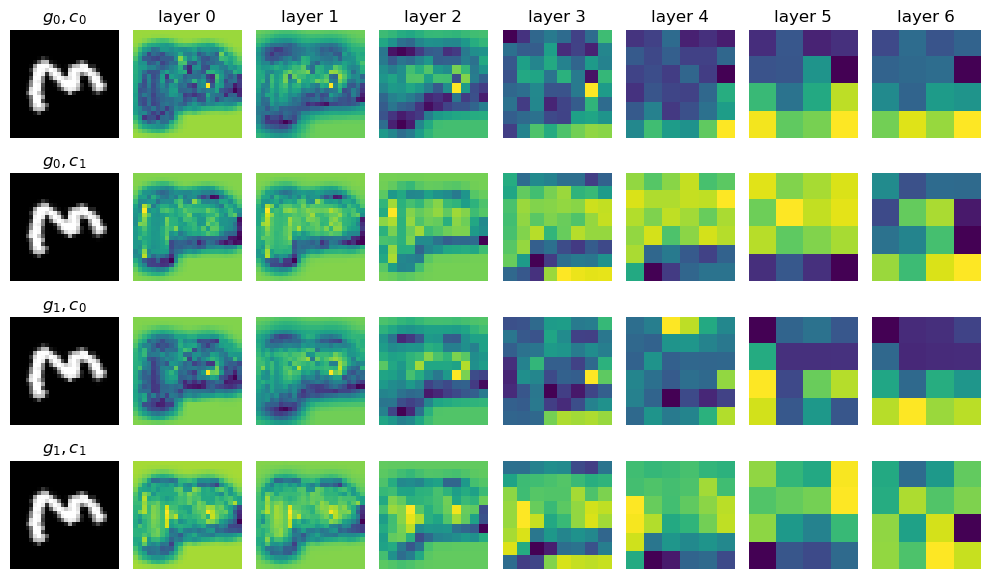

3 with probability 1.0
torch.Size([1, 20, 8, 24, 24])


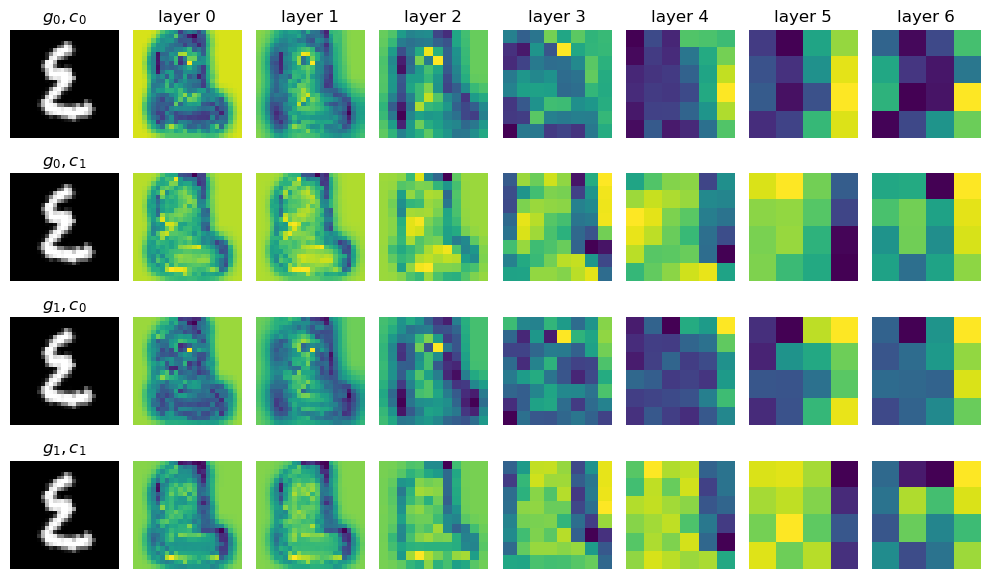

3 with probability 0.9999984502792358
torch.Size([1, 20, 8, 24, 24])


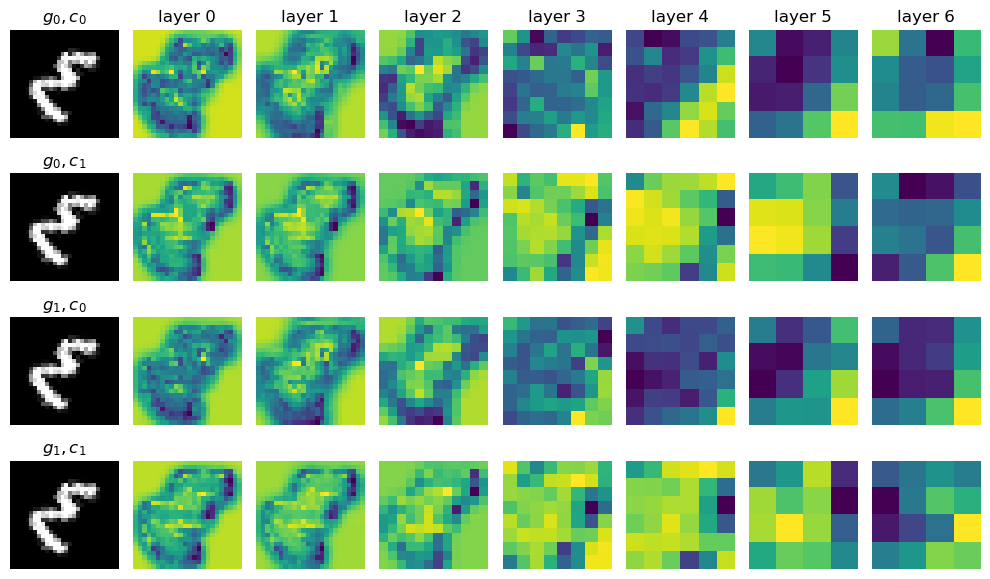

3 with probability 0.9998021721839905
torch.Size([1, 20, 8, 24, 24])


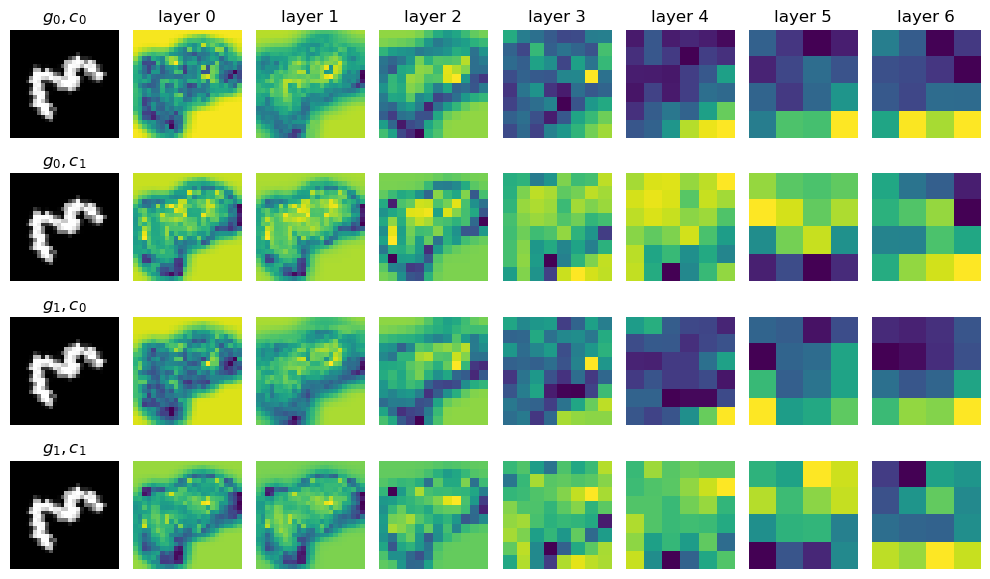

3 with probability 1.0
torch.Size([1, 20, 8, 24, 24])


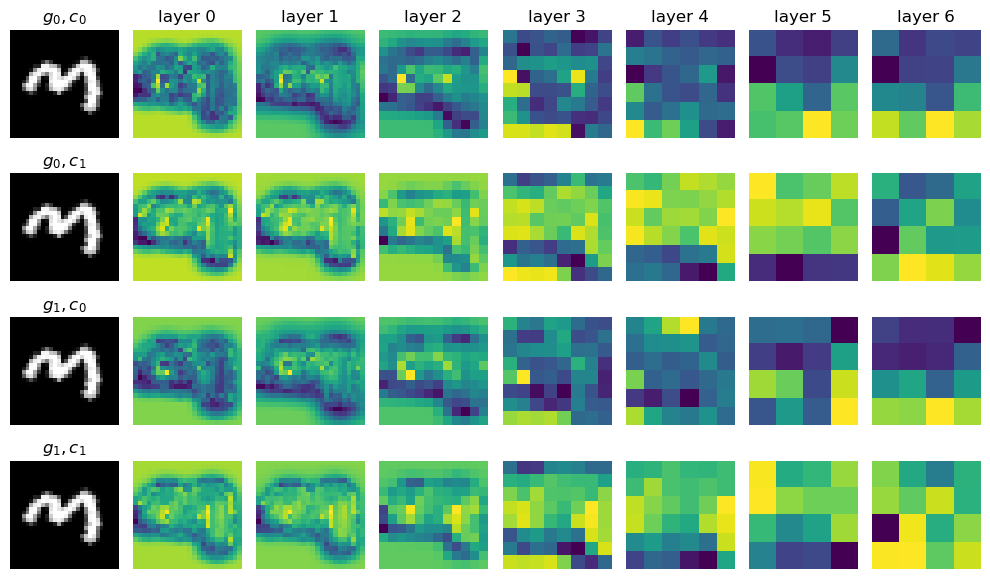

3 with probability 1.0
torch.Size([1, 20, 8, 24, 24])


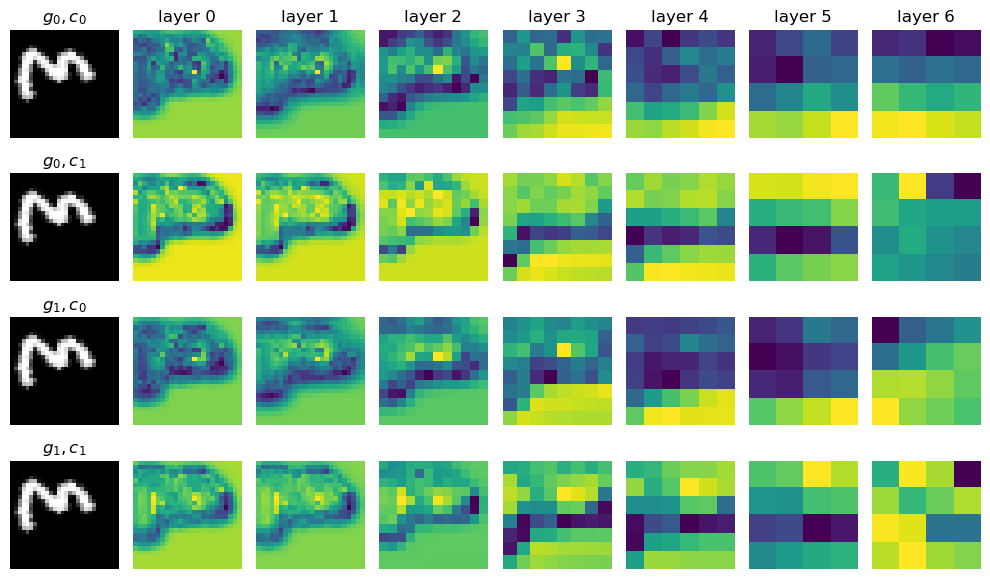

++++++++++++++++++++++++++++++


In [12]:
import torchvision.transforms.functional


idx_2_target = {
    0: 3,
    1: 8
}


model.eval()
with torch.no_grad():
    for gif_ctr in range(1):
        example_image, example_idx = next(data)
        pil_image = Image.fromarray(example_image[0,0].numpy())
        bg_color = example_image[0,0,0,0]
        rotated_image = pil_image.rotate(90, fillcolor=bg_color)
        rotated_image_tensor = torchvision.transforms.functional.pil_to_tensor(rotated_image).unsqueeze(1)
        rotated_image_2 = pil_image.rotate(45, fillcolor=bg_color)
        rotated_image_2_tensor = torchvision.transforms.functional.pil_to_tensor(rotated_image_2).unsqueeze(1)
        rotated_image_3 = pil_image.rotate(20, fillcolor=bg_color)
        rotated_image_3_tensor = torchvision.transforms.functional.pil_to_tensor(rotated_image_3).unsqueeze(1)
        flipped_image = ImageOps.mirror(pil_image)
        flipped_image_tensor = torchvision.transforms.functional.pil_to_tensor(flipped_image).unsqueeze(1)
        translated_image = pil_image.transform(pil_image.size, Image.AFFINE, (1, 0, 3, 0, 1, 3), fillcolor=bg_color) 
        # fillcolor is set assuming that top left of image is the background color 
        translated_image_tensor = torchvision.transforms.functional.pil_to_tensor(translated_image).unsqueeze(1)
        print(f"Target: {idx_2_target[example_idx.item()]}")
        img_ctr = 0
        for image in [example_image, rotated_image_tensor, rotated_image_2_tensor, rotated_image_3_tensor,
                      flipped_image_tensor, translated_image_tensor]:
            out = model(image)
            features = model(image, show_features=True)
            image = image.squeeze()  # Batch dimension
            _, preds = torch.max(out, 1)
            print(f"{idx_2_target[preds.item()]} with probability {torch.softmax(out, dim=1)[0][preds].item()}")
            print(features[0].shape) # [batch size, channels, group elements, x ,y]
            plt.figure(figsize=(10, 6))
            n_plotted_group_elements = 4

            for j in range(n_plotted_group_elements):
                for i in range(len(features)):
                    if i==0: 
                        plt.subplot(n_plotted_group_elements, len(features)+1, j*(len(features)+1) + 1)
                        if j == 0: plt.title('$g_0, c_0$')
                        if j == 1: plt.title('$g_0, c_1$')
                        if j == 2: plt.title('$g_1, c_0$')
                        if j == 3: plt.title('$g_1, c_1$')
                        plt.imshow(image.cpu().numpy(), cmap="gray")
                        plt.axis('off')
                    plt.subplot(n_plotted_group_elements, len(features)+1, j*(len(features)+1) + i+2)
                    if j==0: plt.title(f'layer {i}')
                    if j==0: plt.imshow(features[i][0,0,0])
                    if j==1: plt.imshow(features[i][0,1,0])
                    if j==2: plt.imshow(features[i][0,0,1])
                    if j==3: plt.imshow(features[i][0,1,1])
                    plt.axis('off')

            plt.tight_layout()
                img_ctr += 1
            plt.show()
        print("++++++++++++++++++++++++++++++")


In [13]:
!pip install --upgrade pillow

  Using cached pillow-10.3.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.2 kB)
Using cached pillow-10.3.0-cp311-cp311-manylinux_2_28_x86_64.whl (4.5 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 10.0.1
    Uninstalling Pillow-10.0.1:
      Successfully uninstalled Pillow-10.0.1


### Visualising attention values to test equivariance (requires a hacky alternative model)

In [14]:
model2 = models.GroupTransformer(
    group=groups.E2(num_elements=8),
    in_channels=1,
    num_channels=20,
    block_sizes=[2, 3],
    expansion_per_block=1,
    crop_per_layer=[2, 0, 2, 1, 1],
    image_size=28,
    num_classes=2,
    dropout_rate_after_maxpooling=0.0,
    maxpool_after_last_block=False,
    normalize_between_layers=False,
    patch_size=5,
    num_heads=9,
    norm_type="LayerNorm",
    activation_function="Swish",
    attention_dropout_rate=0.1,
    value_dropout_rate=0.1,
    whitening_scale=1.41421356,
    return_attn_probs=True,
)
model_path = "checkpoints/rotMNIST_model_p4msa_type_Local_patch_5_dpatt_0.1_dpval_0.1_activ_Swish_norm_LayerNorm_white_1.41421356_optim_Adam_lr_0.001_bs_16_ep_50_wd_0.0001_seed_0_sched_constants_schdec_1.0.pt"
device2 = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = torch.nn.DataParallel(model2)
model2.load_state_dict(torch.load(model_path, map_location=device2), strict=False)

<All keys matched successfully>

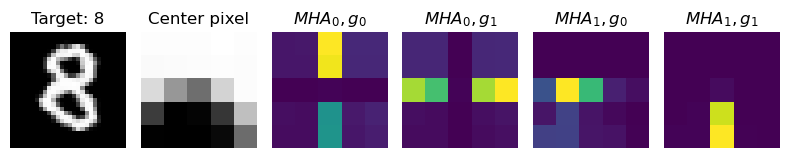

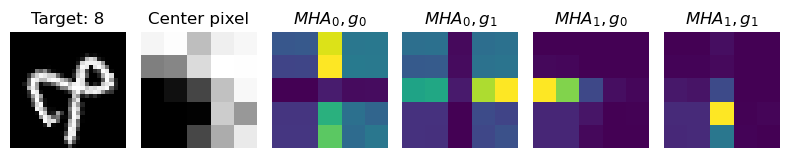

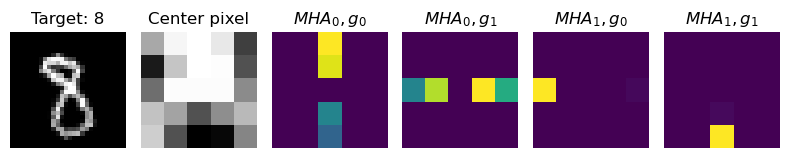

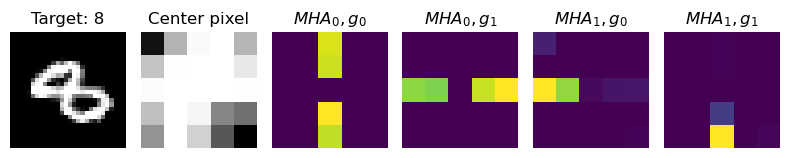

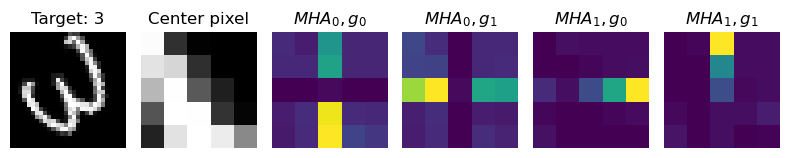

In [16]:
idx_2_target = {
    0: 3,
    1: 8
}

model2.eval()
with torch.no_grad():
    for img_ctr in range(5):
        example_image, example_idx = next(data)
        out, attn = model2(example_image)
        # attn.shape = B, N_heads, group_el, im_width, im_height, local_neigh_w, local_neigh, h
        plt.figure(figsize=(8,2))
        plt.subplot(161)
        plt.axis('off')
        plt.title(f"Target: {idx_2_target[example_idx.item()]}")
        plt.imshow(example_image.cpu().squeeze().numpy(), cmap="gray")
        plt.subplot(162)
        plt.axis('off')
        plt.title('Center pixel')
        plt.imshow(example_image.cpu().squeeze().numpy()[14-2:14+3,14-2:14+3], cmap='gray')
        plt.subplot(163)
        plt.axis('off')
        plt.title('$MHA_0, g_0$')
        attn_image = attn[0,0,0,14,14,:,:].cpu().numpy()
        plt.imshow(attn_image)
        plt.subplot(164)
        plt.axis('off')
        plt.title('$MHA_0, g_1$')
        attn_image = attn[0,0,1,14,14,:,:].cpu().numpy()
        plt.imshow(attn_image)
        plt.subplot(165)
        plt.axis('off')
        plt.title('$MHA_1, g_0$')
        attn_image = attn[0,1,0,14,14,:,:].cpu().numpy()
        plt.imshow(attn_image)
        plt.subplot(166)
        plt.axis('off')
        plt.title('$MHA_1, g_1$')
        attn_image = attn[0,1,1,14,14,:,:].cpu().numpy()
        plt.imshow(attn_image)
        plt.tight_layout()
        # plt.savefig(f'gif_tmps/attention/tmp{img_ctr}.png')
        plt.show()

### Visualising embedding weights

#### Embedding weights (lifting layer)

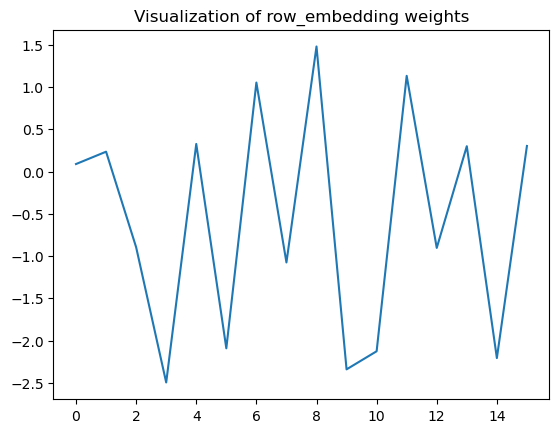

In [17]:
module = model.module
weights = module.lifting_self_attention.row_embedding[0].weight.detach().cpu().numpy()

plt.plot(weights.squeeze())
plt.title('Visualization of row_embedding weights')
plt.show()

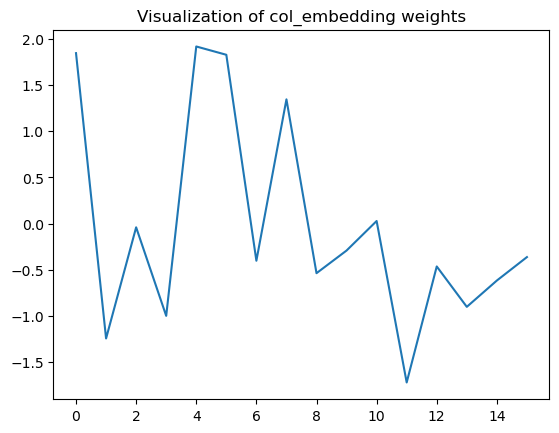

In [18]:
weights = module.lifting_self_attention.col_embedding[0].weight.detach().cpu().numpy()
plt.plot(weights.squeeze())
plt.title('Visualization of col_embedding weights')
plt.show()

#### Embedding indices (lifting layer)

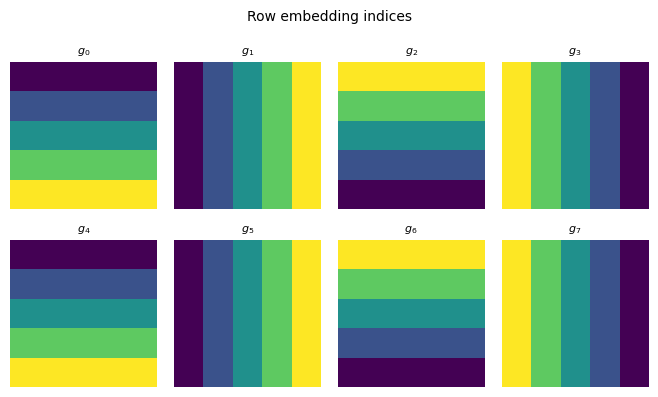

In [19]:
row_indices = module.lifting_self_attention.row_indices

plt.figure(figsize=(8,4))
plt.subplots_adjust(bottom=0.85)
plt.suptitle('Row embedding indices',size=10)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.title(f'$g_{i}$',size=8)
    plt.imshow(row_indices[i])
    plt.axis('off')

plt.tight_layout()
# plt.savefig('row_embd_idxs.png')
plt.show()

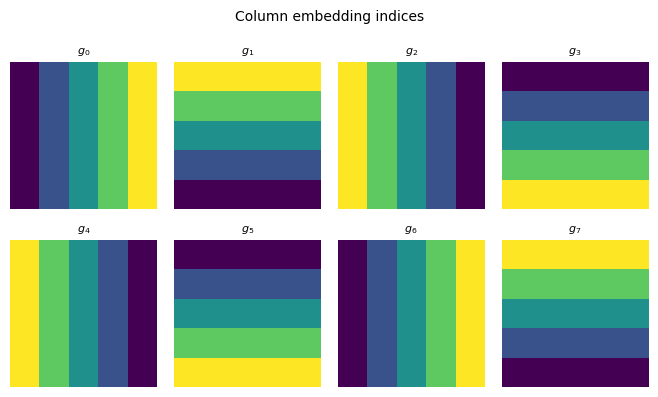

In [20]:
col_indices = module.lifting_self_attention.col_indices

plt.figure(figsize=(8,4))
plt.subplots_adjust(bottom=0.85)
plt.suptitle('Column embedding indices',size=10)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.title(f'$g_{i}$',size=8)
    plt.imshow(col_indices[i])
    plt.axis('off')

plt.tight_layout()
# plt.savefig('col_embd_idxs.png')
plt.show()

#### Embedding indices (transformer block 0)

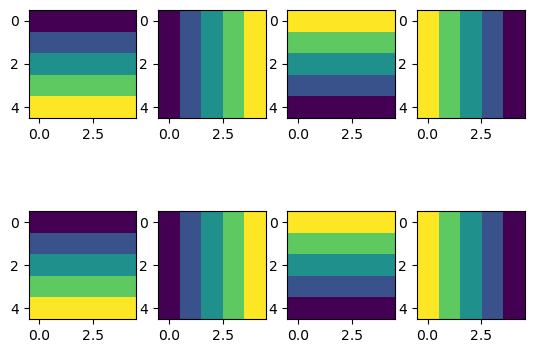

In [21]:
row_indices = module.transformer[0].attention[2].row_indices

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(row_indices[i])

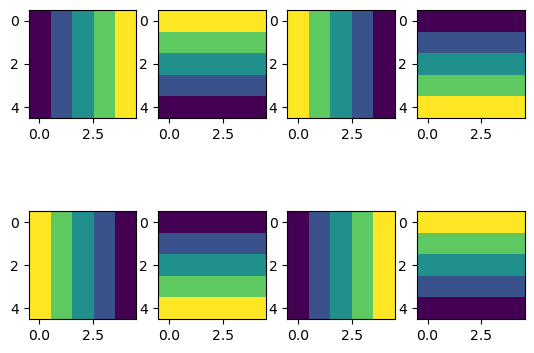

In [22]:
col_indices = module.transformer[0].attention[2].col_indices

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(col_indices[i])

#### Final embedding (transformer block 0)

torch.Size([8, 5, 5])
(8, 5, 5, 3)


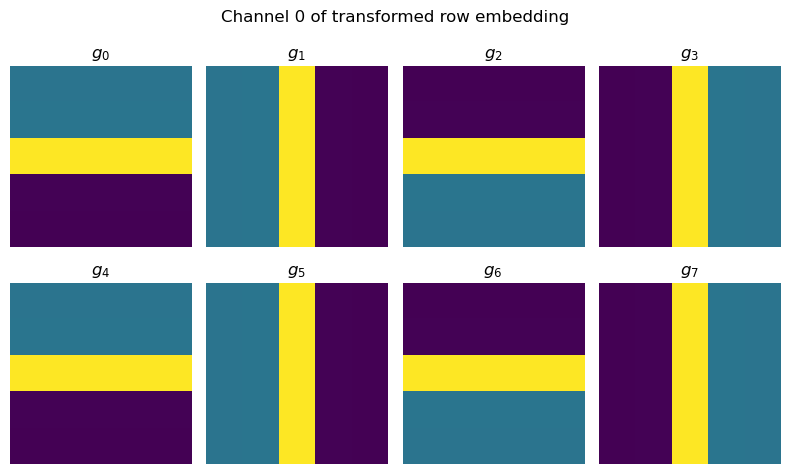

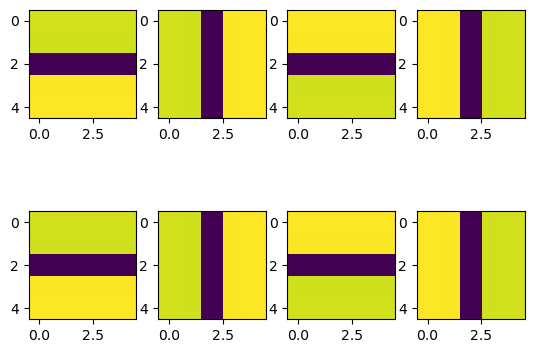

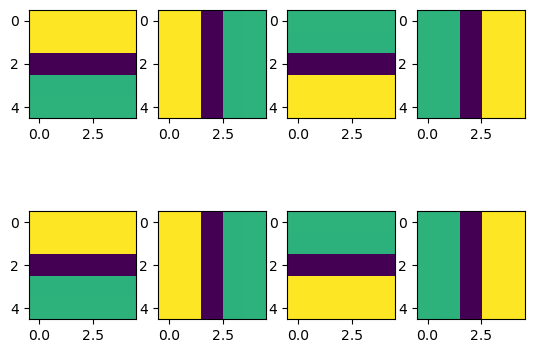

In [23]:
row_indices = module.transformer[0].attention[2].row_indices

print(row_indices.shape)

final_row_embedding = module.transformer[0].attention[2].row_embedding(row_indices.view(-1, 1, 1, 1)).view(row_indices.shape + (-1,)).detach().numpy()

print(final_row_embedding.shape)

plt.figure(figsize=(8,5))

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_row_embedding[i,:,:,0])
    plt.title(f'$g_{i}$')
    plt.axis('off')

plt.suptitle('Channel 0 of transformed row embedding')
plt.tight_layout()
plt.savefig('row_embd_final.png')
plt.show()

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_row_embedding[i,:,:,1])

plt.show()

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_row_embedding[i,:,:,2])

plt.show()


torch.Size([8, 5, 5])
(8, 5, 5, 3)


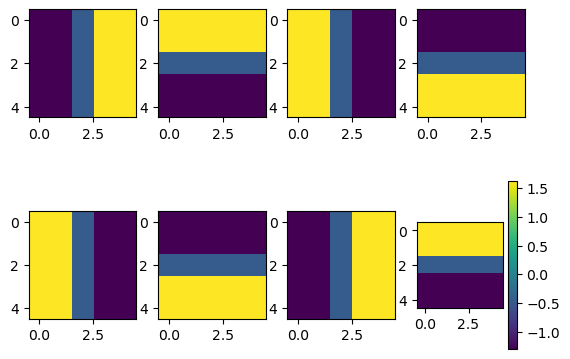

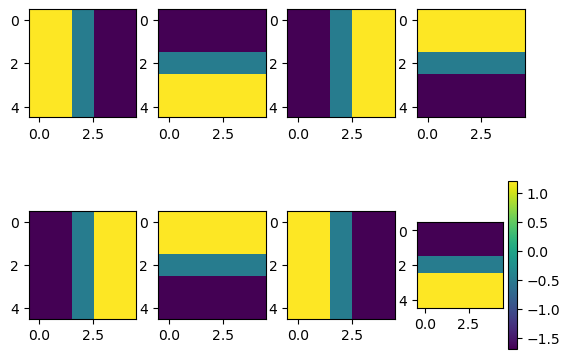

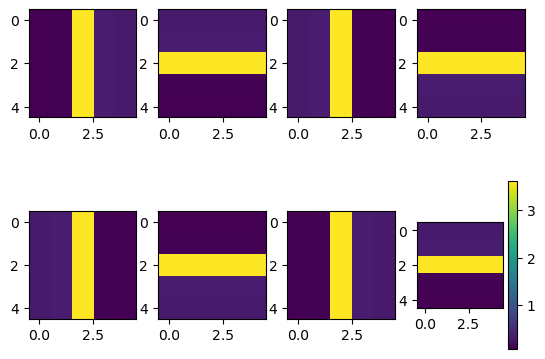

In [24]:
col_indices = module.transformer[0].attention[2].col_indices

print(col_indices.shape)

final_col_embedding = module.transformer[0].attention[2].col_embedding(col_indices.view(-1, 1, 1, 1)).view(col_indices.shape + (-1,)).detach().numpy()

print(final_col_embedding.shape)

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_col_embedding[i,:,:,0])

plt.colorbar()

plt.show()

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_col_embedding[i,:,:,1])

plt.colorbar()

plt.show()

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_col_embedding[i,:,:,2])

plt.colorbar()

plt.show()


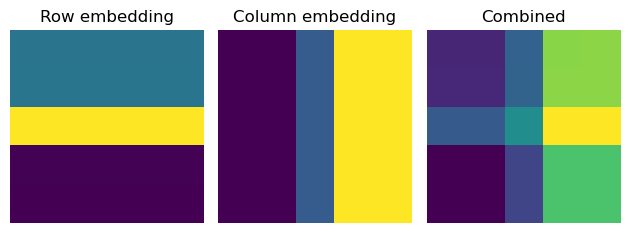

In [26]:
# Attempt to visualize combination of relative row and col embeddings
final_row_embedding = module.transformer[0].attention[2].row_embedding(row_indices.view(-1, 1, 1, 1)).view(row_indices.shape + (-1,)).detach().numpy()
final_col_embedding = module.transformer[0].attention[2].col_embedding(col_indices.view(-1, 1, 1, 1)).view(col_indices.shape + (-1,)).detach().numpy()

row = final_row_embedding[0,:,:,0]
col = final_col_embedding[0,:,:,0]

plt.subplot(131)
plt.title('Row embedding')
plt.imshow(row)
plt.axis('off')
plt.subplot(132)
plt.title('Column embedding')
plt.imshow(col)
plt.axis('off')
plt.subplot(133)
plt.title('Combined')
plt.imshow(row+col)
plt.axis('off')

plt.tight_layout()

# plt.savefig('combined_embd.png')
plt.show()

#### Final embedding (transformer block 2)

torch.Size([8, 5, 5])
(8, 5, 5, 3)


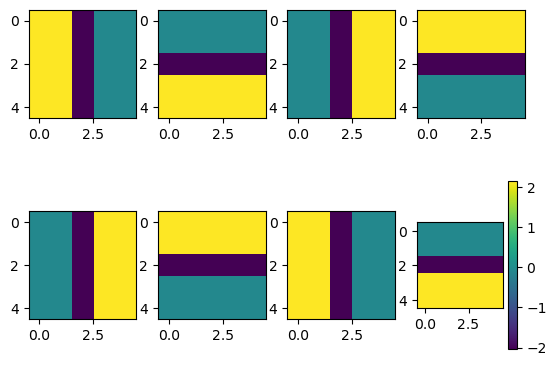

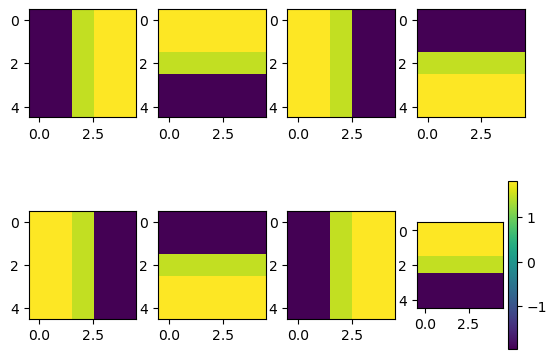

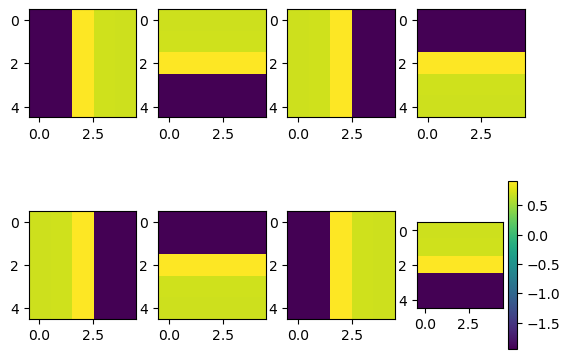

In [27]:
col_indices = module.transformer[3].attention[2].col_indices

print(col_indices.shape)

final_col_embedding = module.transformer[3].attention[2].col_embedding(col_indices.view(-1, 1, 1, 1)).view(col_indices.shape + (-1,)).detach().numpy()
final_col_embedding = module.transformer[3].attention[2].col_embedding(col_indices.view(-1, 1, 1, 1)).view(col_indices.shape + (-1,)).detach().numpy()

print(final_col_embedding.shape)

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_col_embedding[i,:,:,0])

plt.colorbar()

plt.show()

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_col_embedding[i,:,:,1])

plt.colorbar()

plt.show()

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_col_embedding[i,:,:,2])

plt.colorbar()

plt.show()


#### Embedding summary

What it comes down to:
- These embeddings are for an area around a given pixel to embed the relative position to the center.
- You can see that the relative row/col embeddings mostly work to distinguish relative position, but that it is group action'ed for every group element to stay equivariant.

#### Distances between embeddings

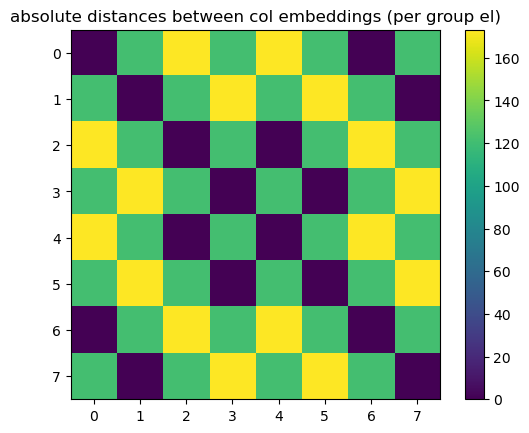

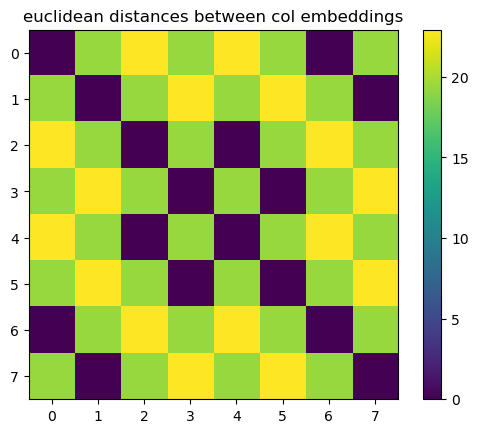

In [28]:
embeds = [final_col_embedding[i] for i in range(8)]

dists_abs = np.zeros((8,8))
dists_euc = np.zeros((8,8))

for i in range(8):
    for j in range(8):
        dists_abs[i][j] = np.sum(np.abs(embeds[i] - embeds[j]))
        dists_euc[i][j] = np.sqrt(np.sum((embeds[i] - embeds[j])**2))

plt.title('absolute distances between col embeddings (per group el)')
plt.imshow(dists_abs)
plt.colorbar()
plt.show()

plt.title('euclidean distances between col embeddings')
plt.imshow(dists_euc)
plt.colorbar()
plt.show()


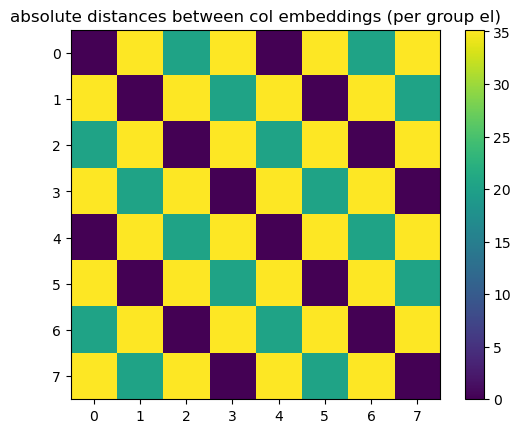

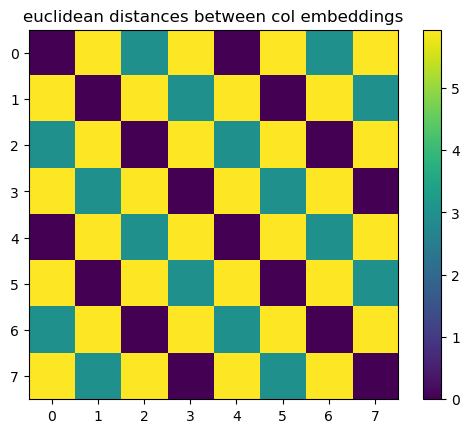

In [29]:
embeds = [final_row_embedding[i] for i in range(8)]

dists_abs = np.zeros((8,8))
dists_euc = np.zeros((8,8))

for i in range(8):
    for j in range(8):
        dists_abs[i][j] = np.sum(np.abs(embeds[i] - embeds[j]))
        dists_euc[i][j] = np.sqrt(np.sum((embeds[i] - embeds[j])**2))

plt.title('absolute distances between col embeddings (per group el)')
plt.imshow(dists_abs)
plt.colorbar()
plt.show()

plt.title('euclidean distances between col embeddings')
plt.imshow(dists_euc)
plt.colorbar()
plt.show()


## transformer block 0 embedding kernel weight visualisation

(16, 1, 1, 1)


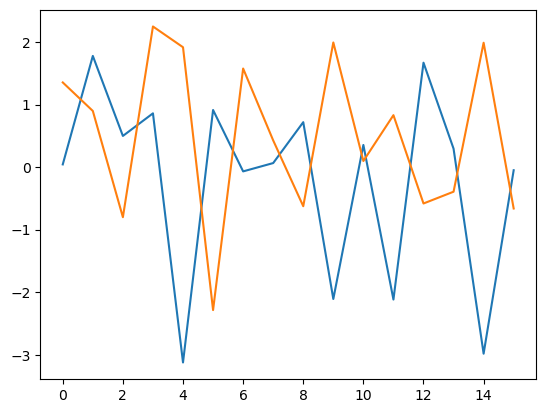

In [30]:
weights_row = module.transformer[0].attention[2].row_embedding[0].weight.detach().cpu().numpy()
weights_col = module.transformer[0].attention[2].col_embedding[0].weight.detach().cpu().numpy()

plt.plot(weights_row.squeeze())
plt.plot(weights_col.squeeze())

print(weights_col.shape)

plt.show()

(3, 16)


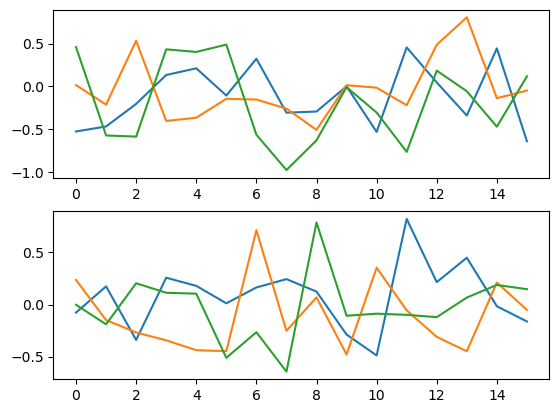

In [32]:
weights_row = module.transformer[0].attention[2].row_embedding[3].weight.detach().cpu().numpy()
weights_col = module.transformer[0].attention[2].col_embedding[3].weight.detach().cpu().numpy()

print(weights_row.squeeze().shape)
plt.subplot(211)
plt.plot(weights_col.squeeze().T)
plt.subplot(212)
plt.plot(weights_row.squeeze().T)
plt.show()

[ 1.355378    0.8991513  -0.800233    2.2508502   1.9188323  -2.28629
  1.578074    0.42812335 -0.6247775   1.9950341   0.09863157  0.83197385
 -0.581095   -0.39266762  1.9909202  -0.6613471 ]


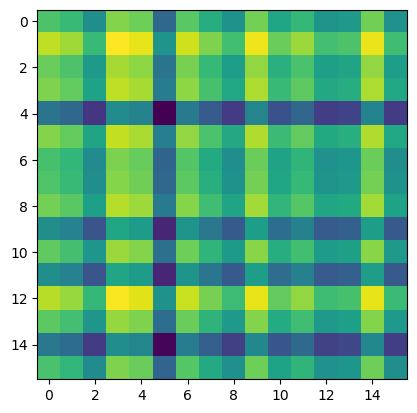

In [33]:
weights_row = module.transformer[0].attention[2].row_embedding[0].weight.detach().cpu().numpy()
weights_col = module.transformer[0].attention[2].col_embedding[0].weight.detach().cpu().numpy()

print(weights_col.squeeze())

combo = np.zeros((16, 16))

for i in range(16):
    for j in range(16):
        combo[i][j] = weights_row.squeeze()[i] + weights_col.squeeze()[j]

plt.imshow(combo)

plt.show()

(16,)


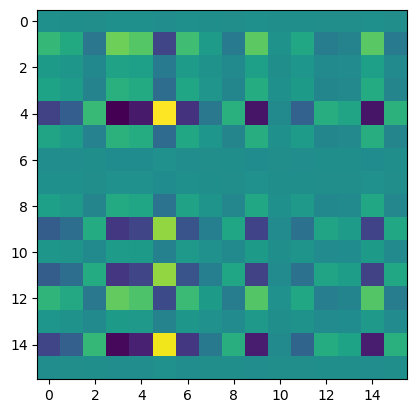

In [34]:
weights_row = module.transformer[0].attention[2].row_embedding[0].weight.detach().cpu().numpy()
weights_col = module.transformer[0].attention[2].col_embedding[0].weight.detach().cpu().numpy()

print(weights_row.squeeze().shape)


combo = np.zeros((16, 16))

for i in range(16):
    for j in range(16):
        combo[i][j] = weights_row.squeeze()[i] * weights_col.squeeze()[j]

plt.imshow(combo)
plt.show()

# Untrained model tests

In [35]:
model = models.GroupTransformer(
    group=groups.E2(num_elements=8),
    in_channels=1,
    num_channels=20,
    block_sizes=[2, 3],
    expansion_per_block=1,
    crop_per_layer=[2, 0, 2, 1, 1],
    image_size=28,
    num_classes=2,
    dropout_rate_after_maxpooling=0.0,
    maxpool_after_last_block=False,
    normalize_between_layers=False,
    patch_size=5,
    num_heads=9,
    norm_type="LayerNorm",
    activation_function="Swish",
    attention_dropout_rate=0.1,
    value_dropout_rate=0.1,
    whitening_scale=1.41421356,
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.nn.DataParallel(model)


Target: 3


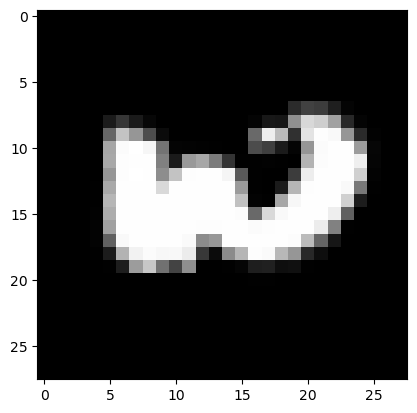

3 with probability 0.9999951124191284
torch.Size([1, 20, 8, 24, 24])


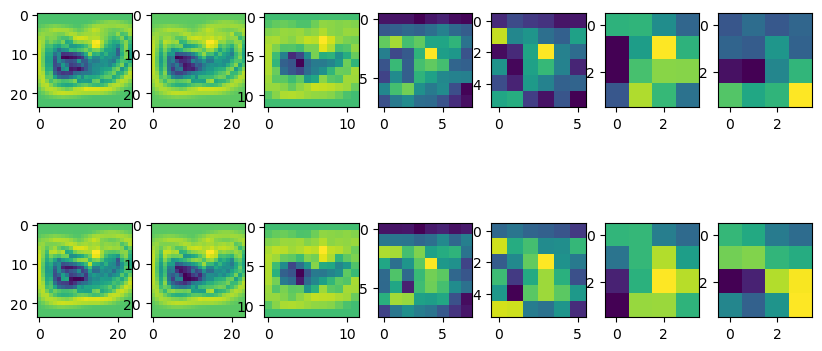

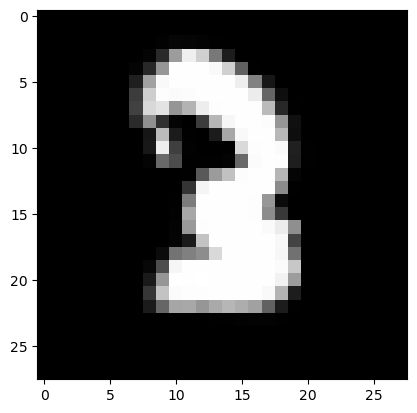

3 with probability 0.9999963045120239
torch.Size([1, 20, 8, 24, 24])


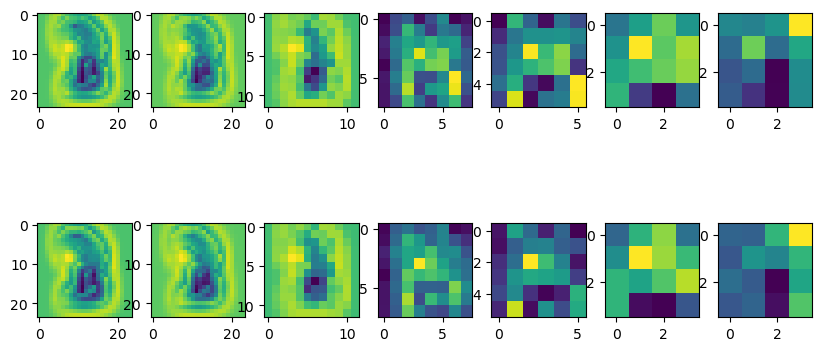

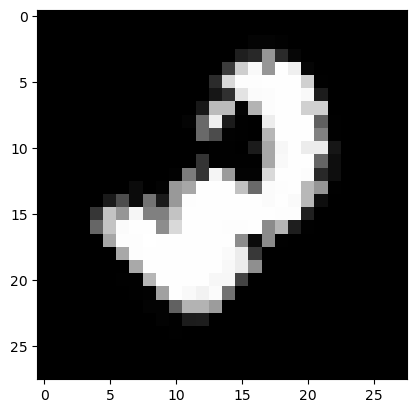

3 with probability 0.9999953508377075
torch.Size([1, 20, 8, 24, 24])


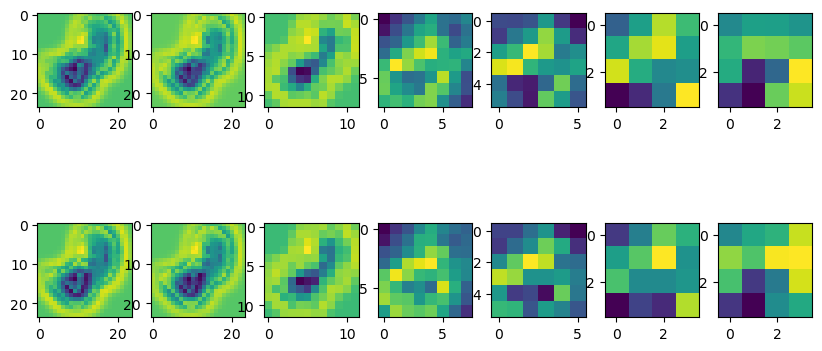

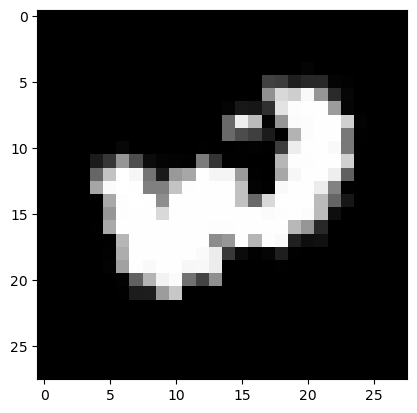

3 with probability 1.0
torch.Size([1, 20, 8, 24, 24])


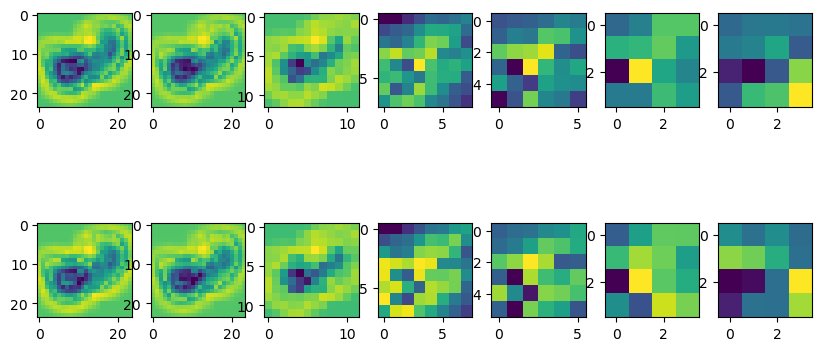

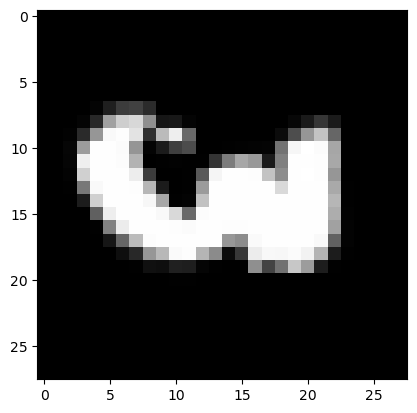

3 with probability 0.9999957084655762
torch.Size([1, 20, 8, 24, 24])


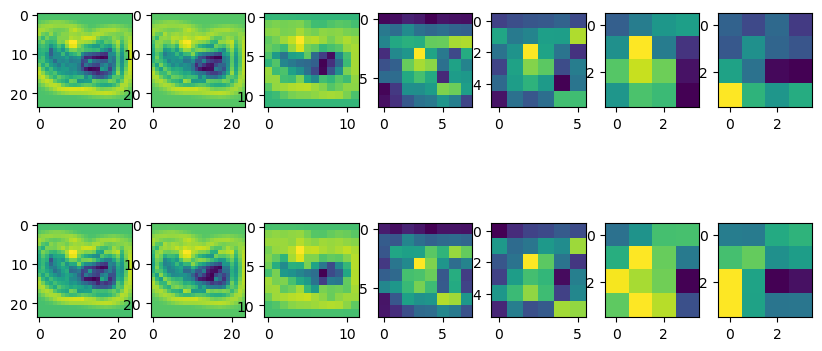

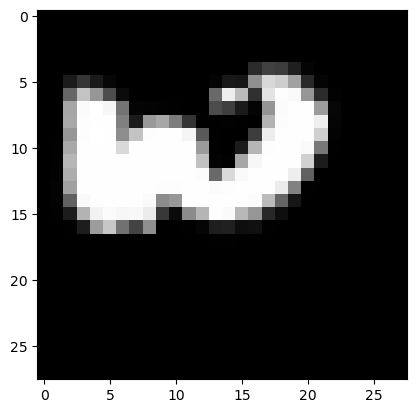

3 with probability 1.0
torch.Size([1, 20, 8, 24, 24])


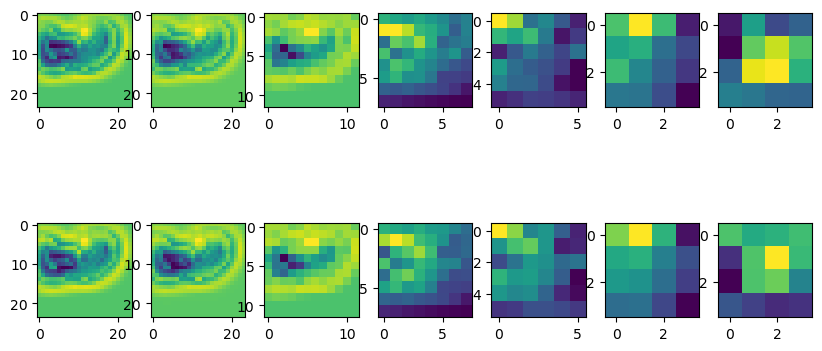

++++++++++++++++++++++++++++++
Target: 8


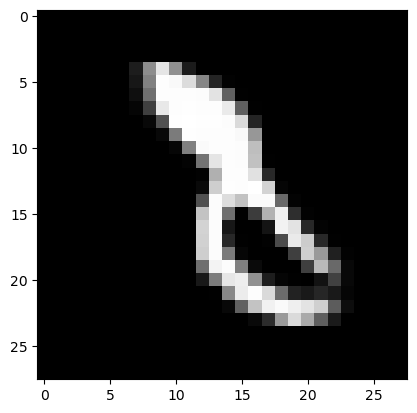

3 with probability 1.0
torch.Size([1, 20, 8, 24, 24])


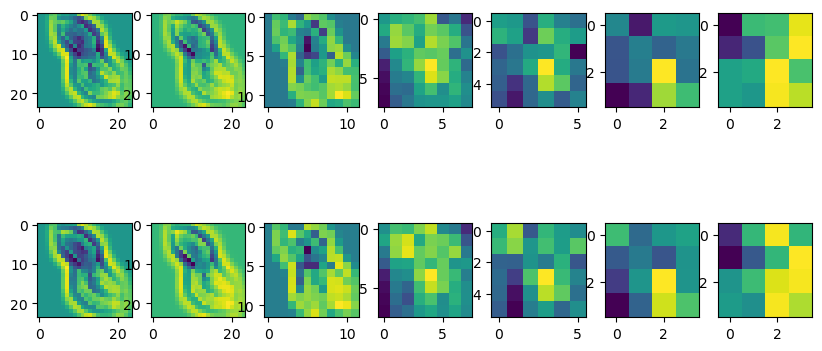

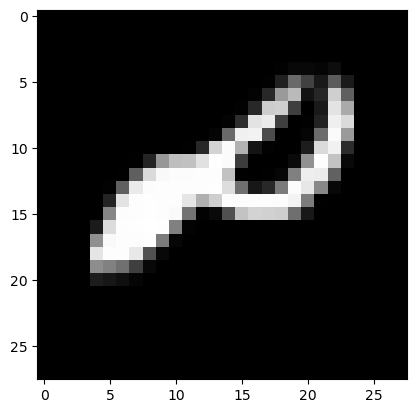

3 with probability 1.0
torch.Size([1, 20, 8, 24, 24])


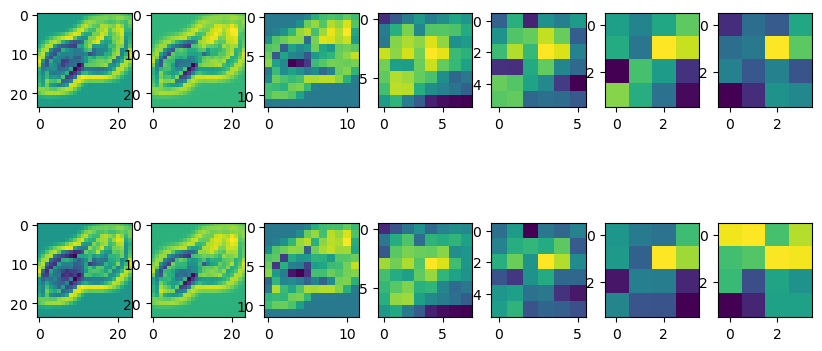

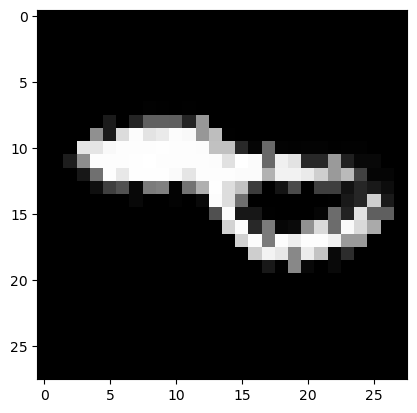

3 with probability 1.0
torch.Size([1, 20, 8, 24, 24])


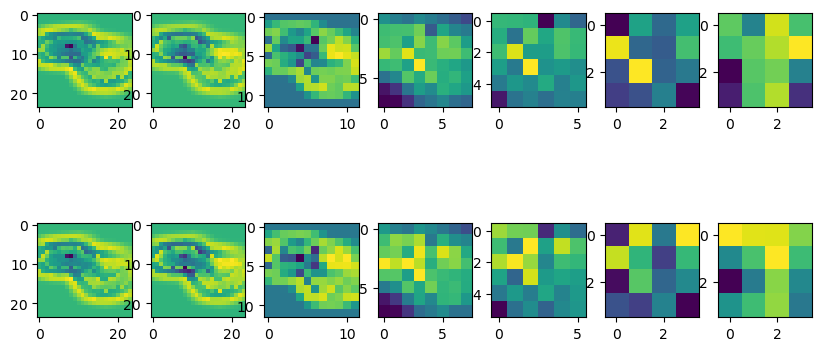

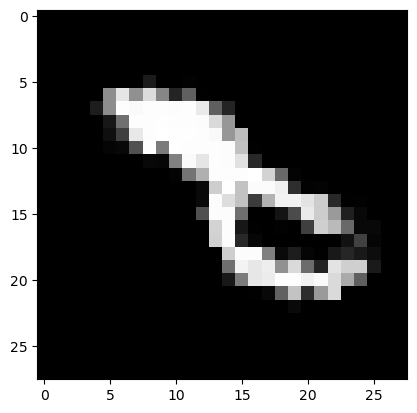

3 with probability 1.0
torch.Size([1, 20, 8, 24, 24])


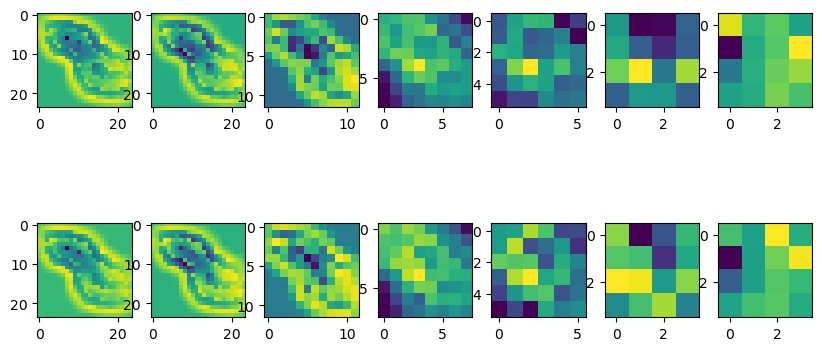

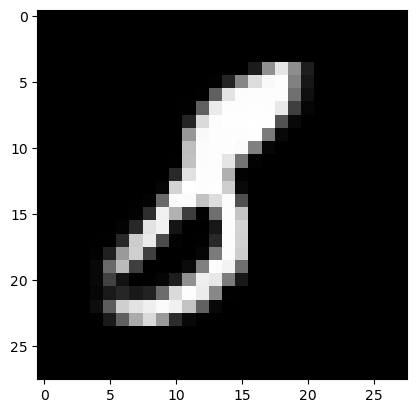

3 with probability 1.0
torch.Size([1, 20, 8, 24, 24])


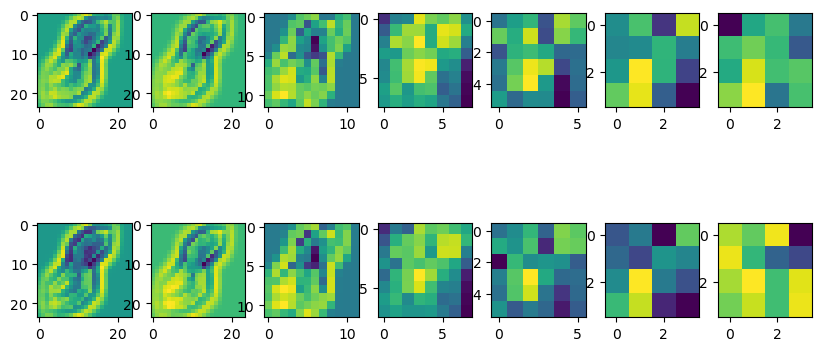

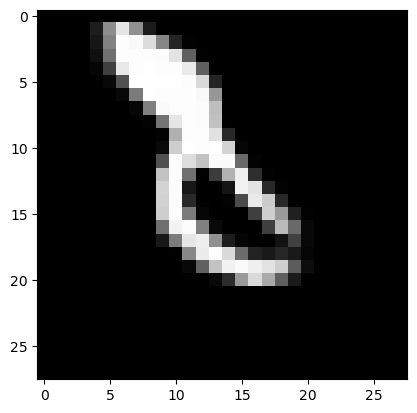

3 with probability 1.0
torch.Size([1, 20, 8, 24, 24])


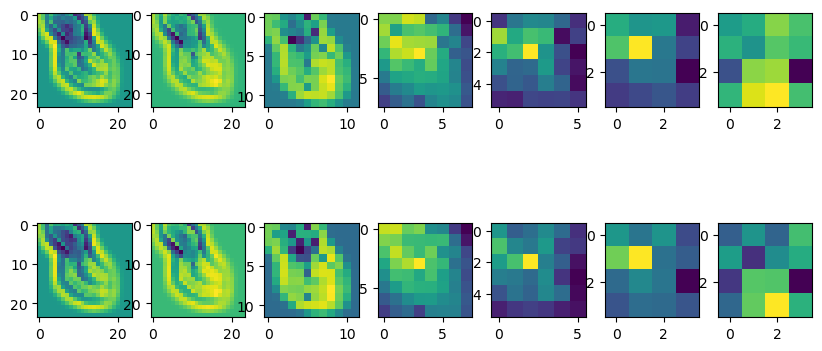

++++++++++++++++++++++++++++++


In [36]:
import torchvision.transforms.functional


idx_2_target = {
    0: 3,
    1: 8
}

model.eval()
with torch.no_grad():
    for _ in range(2):
        example_image, example_idx = next(data)
        pil_image = Image.fromarray(example_image[0,0].numpy())
        bg_color = example_image[0,0,0,0]
        rotated_image = pil_image.rotate(90, fillcolor=bg_color)
        rotated_image_tensor = torchvision.transforms.functional.pil_to_tensor(rotated_image).unsqueeze(1)
        rotated_image_2 = pil_image.rotate(45, fillcolor=bg_color)
        rotated_image_2_tensor = torchvision.transforms.functional.pil_to_tensor(rotated_image_2).unsqueeze(1)
        rotated_image_3 = pil_image.rotate(20, fillcolor=bg_color)
        rotated_image_3_tensor = torchvision.transforms.functional.pil_to_tensor(rotated_image_3).unsqueeze(1)
        flipped_image = ImageOps.mirror(pil_image)
        flipped_image_tensor = torchvision.transforms.functional.pil_to_tensor(flipped_image).unsqueeze(1)
        translated_image = pil_image.transform(pil_image.size, Image.AFFINE, (1, 0, 3, 0, 1, 3), fillcolor=bg_color) 
        # fillcolor is set assuming that top left of image is the background color 
        translated_image_tensor = torchvision.transforms.functional.pil_to_tensor(translated_image).unsqueeze(1)
        print(f"Target: {idx_2_target[example_idx.item()]}")
        for image in [example_image, rotated_image_tensor, rotated_image_2_tensor, rotated_image_3_tensor,
                      flipped_image_tensor, translated_image_tensor]:
            out = model(image)
            features = model(image, show_features=True)
            image = image.squeeze()  # Batch dimension
            plt.imshow(image.cpu().numpy(), cmap="gray")
            plt.show()
            _, preds = torch.max(out, 1)
            print(f"{idx_2_target[preds.item()]} with probability {torch.softmax(out, dim=1)[0][preds].item()}")
            print(features[0].shape) # [batch size, channels, group elements, x ,y]
            plt.figure(figsize=(10, 5))
            n_plotted_group_elements = 2
            for i in range(len(features)):
                for j in range(n_plotted_group_elements):
                    plt.subplot(n_plotted_group_elements, len(features), j*len(features) + i+1)
                    plt.imshow(features[i][0,0,j])
            plt.show()
        print("++++++++++++++++++++++++++++++")

torch.Size([8, 5, 5])
(8, 5, 5, 3)


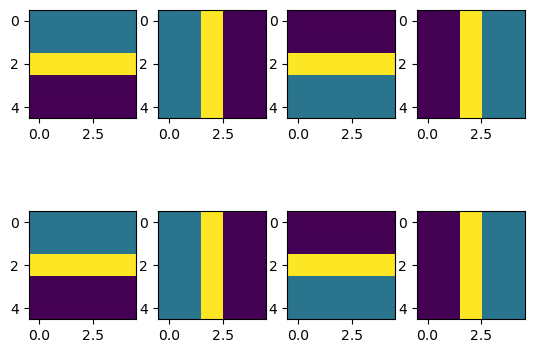

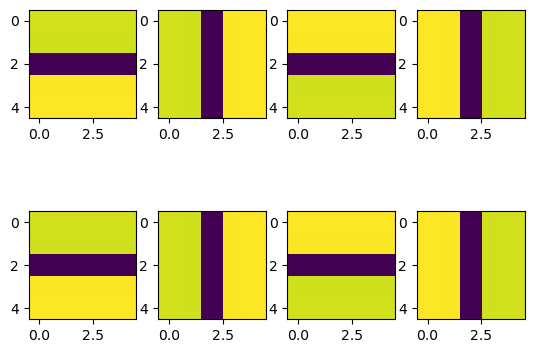

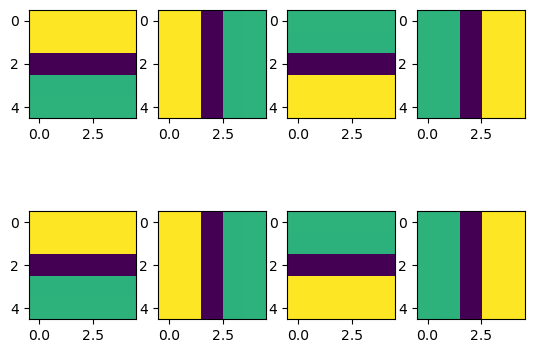

torch.Size([8, 5, 5])
(8, 5, 5, 3)


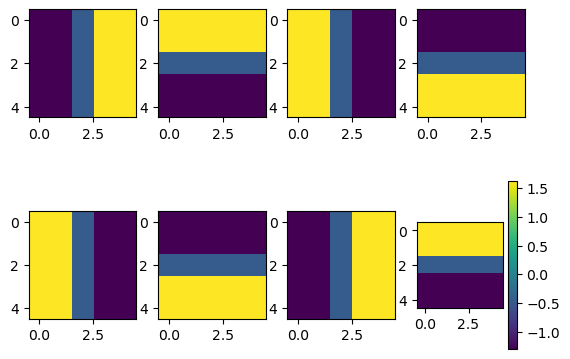

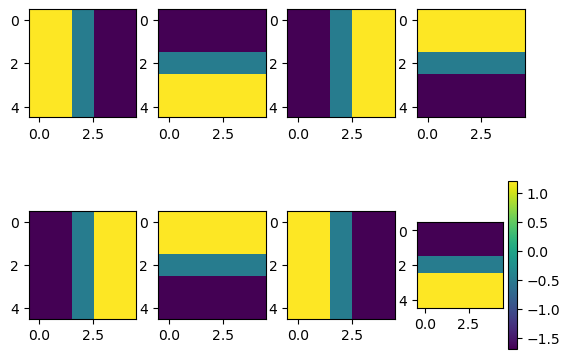

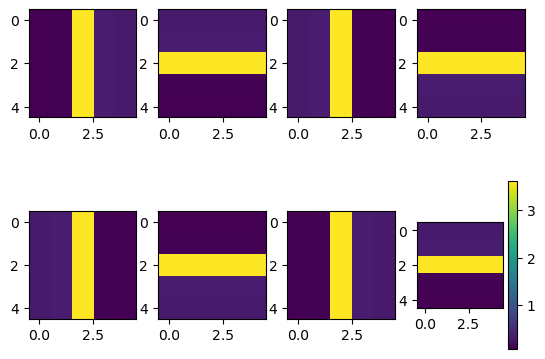

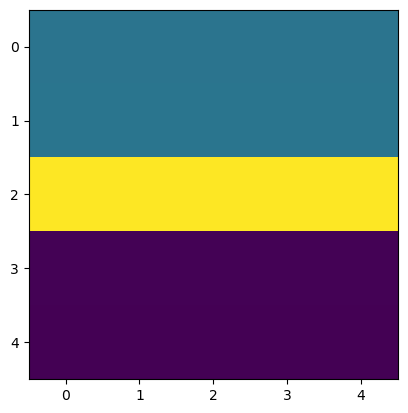

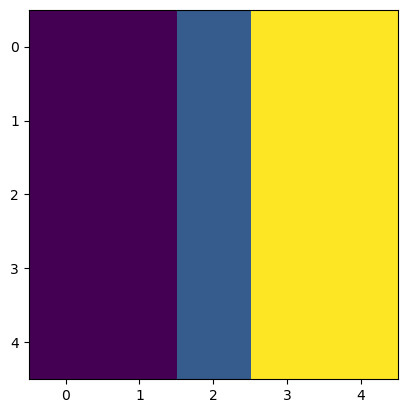

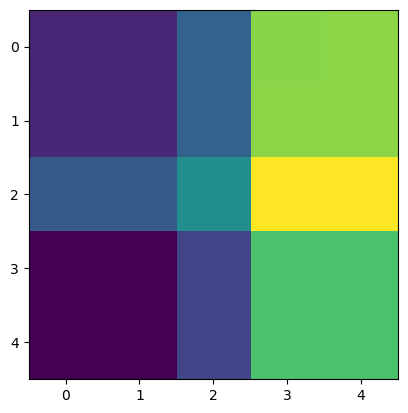

In [37]:
row_indices = module.transformer[0].attention[2].row_indices

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(row_indices[i])

col_indices = module.transformer[0].attention[2].col_indices

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(col_indices[i])

row_indices = module.transformer[0].attention[2].row_indices

print(row_indices.shape)

final_row_embedding = module.transformer[0].attention[2].row_embedding(row_indices.view(-1, 1, 1, 1)).view(row_indices.shape + (-1,)).detach().numpy()

print(final_row_embedding.shape)

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_row_embedding[i,:,:,0])

plt.show()

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_row_embedding[i,:,:,1])

plt.show()

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_row_embedding[i,:,:,2])

plt.show()

col_indices = module.transformer[0].attention[2].col_indices

print(col_indices.shape)

final_col_embedding = module.transformer[0].attention[2].col_embedding(col_indices.view(-1, 1, 1, 1)).view(col_indices.shape + (-1,)).detach().numpy()

print(final_col_embedding.shape)

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_col_embedding[i,:,:,0])

plt.colorbar()

plt.show()

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_col_embedding[i,:,:,1])

plt.colorbar()

plt.show()

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_col_embedding[i,:,:,2])

plt.colorbar()

plt.show()

# Attempt to visualize combination of relative row and col embeddings
final_row_embedding = module.transformer[0].attention[2].row_embedding(row_indices.view(-1, 1, 1, 1)).view(row_indices.shape + (-1,)).detach().numpy()
final_col_embedding = module.transformer[0].attention[2].col_embedding(col_indices.view(-1, 1, 1, 1)).view(col_indices.shape + (-1,)).detach().numpy()

row = final_row_embedding[0,:,:,0]
col = final_col_embedding[0,:,:,0]

plt.imshow(row)
plt.show()
plt.imshow(col)
plt.show()
plt.imshow(row+col)

In [ ]:
# Iterate over named modules
# for name, module in model.named_modules():
    # print(name)

In [ ]:
# todo visualize attention and all the different layers
# just a bunch of explainability